In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Dropout, Dense, Flatten
from tensorflow.keras.layers import MaxPooling1D, LSTM,  GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from scipy.fft import fft
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random

ImportError: Traceback (most recent call last):
  File "c:\Users\Mr Vee\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [ ]:
# Load the dataset
df = pd.read_csv("/kaggle/input/eeg-motor-imagery-bciciv-2a/BCICIV_2a_all_patients.csv")

# Drop NA just in case (though this dataset has none)
df = df.dropna()

# EEG columns (starting from column 4 onwards)
eeg_columns = df.columns[4:]

print("Channels used:", eeg_columns)

Channels used: Index(['EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5',
       'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9',
       'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15',
       'EEG-16'],
      dtype='object')


# *Preprocessing***

In [ ]:
df['label'].unique()

array(['tongue', 'foot', 'right', 'left'], dtype=object)

In [ ]:
df[eeg_columns] = df[eeg_columns].apply(pd.to_numeric, errors='coerce')
df = df.dropna()

# Check class distribution
print("Class distribution before windowing:")
print(df['label'].value_counts())

# Group by epochs
grouped = df.groupby('epoch')
X, y = [], []

target_length = 201

for epoch, group in grouped:
    data = group[eeg_columns].values.T
    if data.shape[1] > target_length:
        data = data[:, :target_length]
    elif data.shape[1] < target_length:
        pad_width = target_length - data.shape[1]
        data = np.pad(data, ((0, 0), (0, pad_width)), mode='constant')
    X.append(data)
    y.append(group['label'].iloc[0])

X = np.array(X)
y = np.array(y)
print(f"X shape after epoch grouping: {X.shape}")
print(f"y shape: {y.shape}")

# Channel-wise normalization
n_samples, n_channels, n_time_points = X.shape
X_normalized = np.zeros_like(X)

for i in range(n_samples):
    for ch in range(n_channels):
        scaler = StandardScaler()
        X_normalized[i, ch, :] = scaler.fit_transform(X[i, ch, :].reshape(-1, 1)).flatten()

# Frequency-domain features
X_freq = np.zeros((n_samples, n_channels, n_time_points // 2 + 1))
for i in range(n_samples):
    for ch in range(n_channels):
        fft_result = fft(X_normalized[i, ch, :])
        X_freq[i, ch, :] = np.abs(fft_result[:n_time_points // 2 + 1])

# Sliding window
window_size = 50
stride = 10
X_windows, y_windows = [], []

for i in range(n_samples):
    data = X_normalized[i]
    freq_data = X_freq[i]
    num_windows = (n_time_points - window_size) // stride + 1

    for w in range(num_windows):
        start = w * stride
        end = start + window_size
        window = data[:, start:end]

        freq_start = (start * (n_time_points // 2 + 1)) // n_time_points
        freq_end = (end * (n_time_points // 2 + 1)) // n_time_points
        freq_window = freq_data[:, freq_start:freq_end]

        if freq_window.shape[1] < window_size:
            freq_window = np.pad(freq_window, ((0, 0), (0, window_size - freq_window.shape[1])), mode='constant')
        elif freq_window.shape[1] > window_size:
            freq_window = freq_window[:, :window_size]

        combined = np.stack([window, freq_window], axis=-1)
        X_windows.append(combined)
        y_windows.append(y[i])

X_windows = np.array(X_windows)
y_windows = np.array(y_windows)
print(f"X_windows shape (before reshape): {X_windows.shape}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_windows)
y_categorical = tf.keras.utils.to_categorical(y_encoded)
print(f"Encoded y shape (categorical): {y_categorical.shape}")

# Reshape: (samples, time_steps, channels, features) -> (samples, time_steps, channels * features)
X_windows = X_windows.transpose(0, 2, 1, 3)
X_windows = X_windows.reshape(X_windows.shape[0], X_windows.shape[1], X_windows.shape[2] * X_windows.shape[3])
print(f"X_windows shape (final): {X_windows.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_windows, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Class distribution before windowing:
label
left      130248
right     130248
foot      115776
tongue    115776
Name: count, dtype: int64
X shape after epoch grouping: (632, 22, 201)
y shape: (632,)
X_windows shape (before reshape): (10112, 22, 50, 2)
Encoded y shape (categorical): (10112, 4)
X_windows shape (final): (10112, 50, 44)
Train: (8089, 50, 44), (8089, 4)
Test: (2023, 50, 44), (2023, 4)


# Visualizations

--- Raw EEG Signal Visualization (Sample) ---


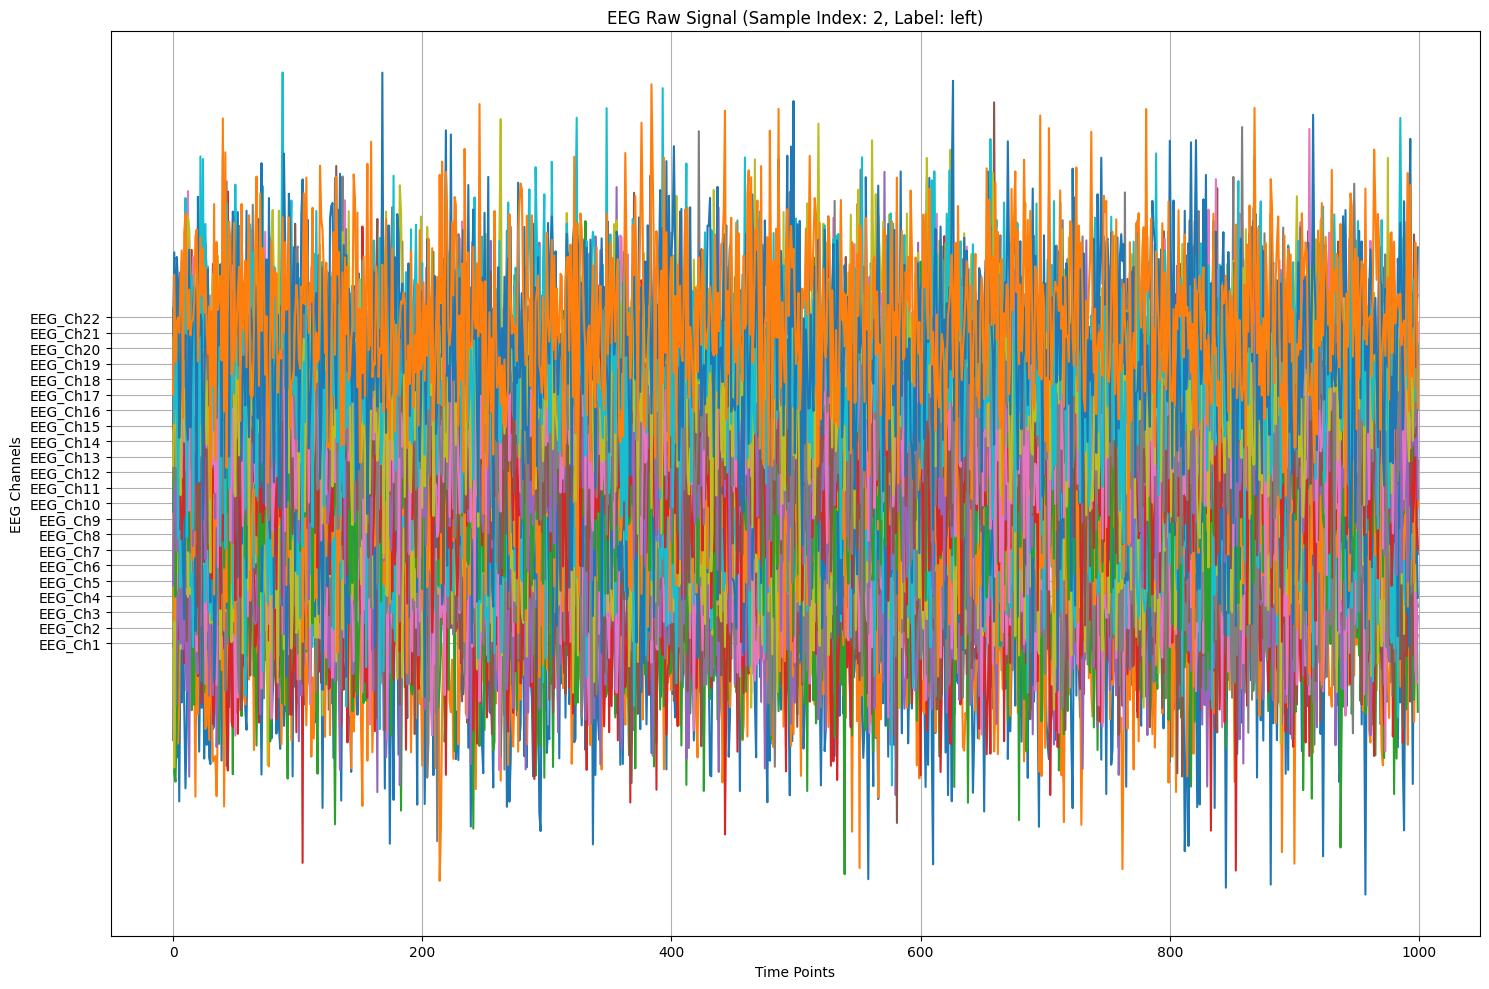


--- Raw vs. Normalized EEG Signal Comparison ---


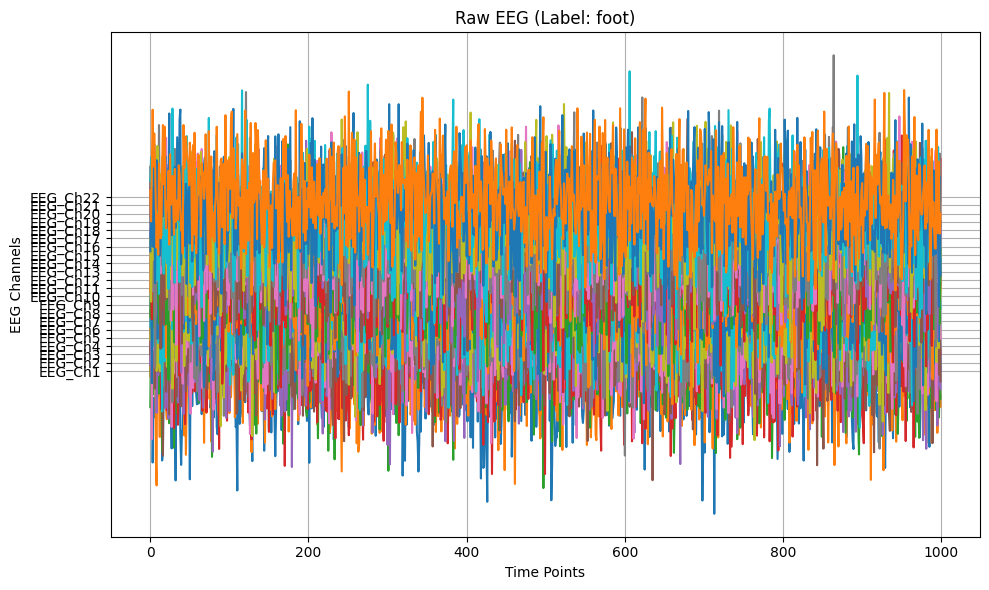

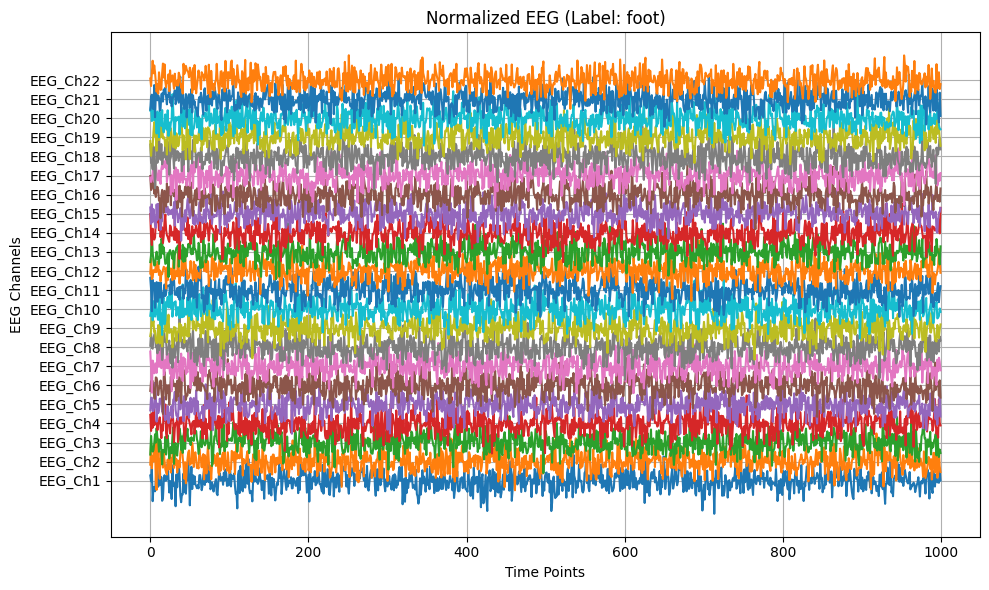


--- EEG Signal Frequency-Domain Visualization (FFT) ---


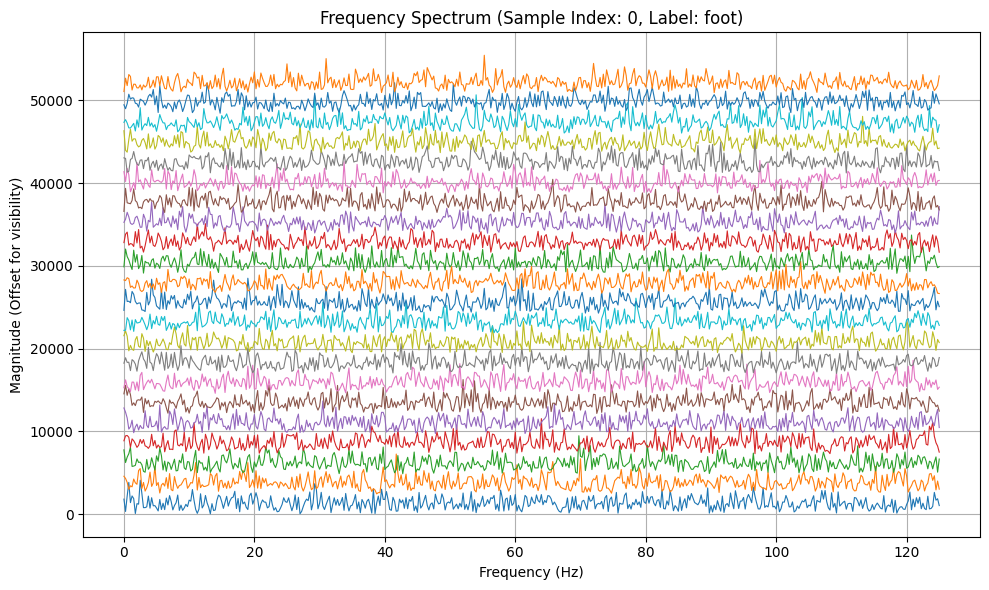


--- Spectrogram-like EEG Heatmap ---


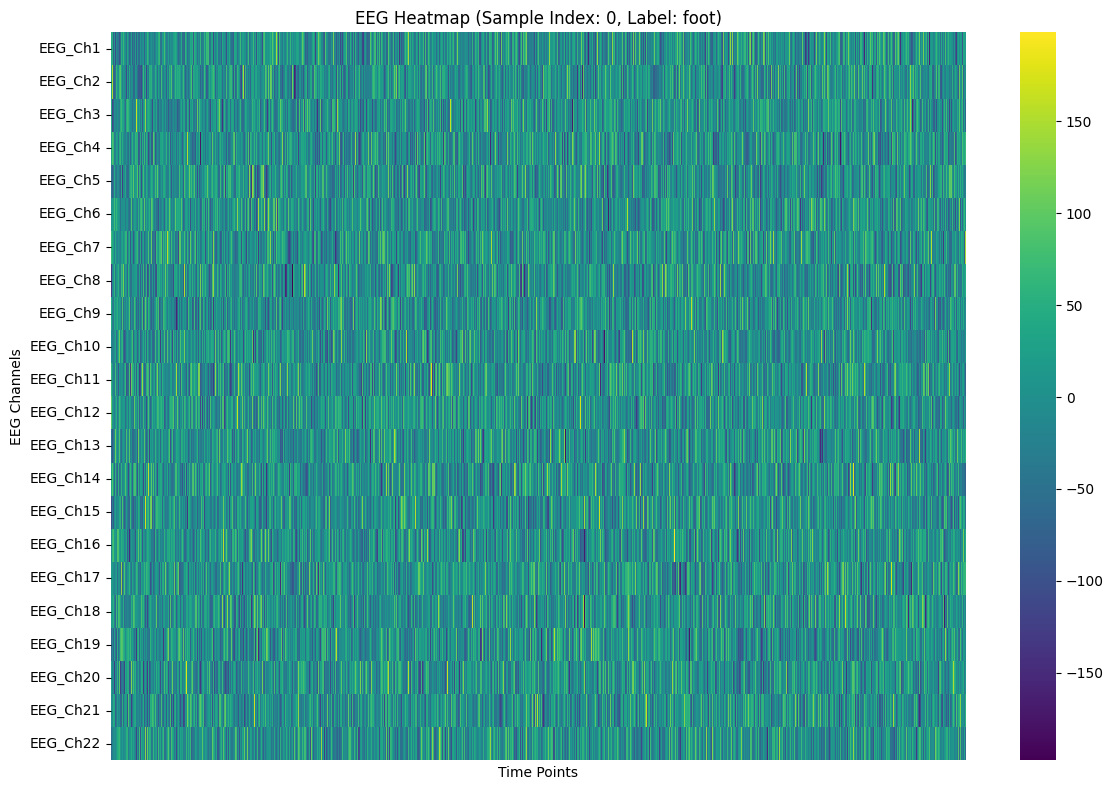


--- EEG Band Power Calculation ---


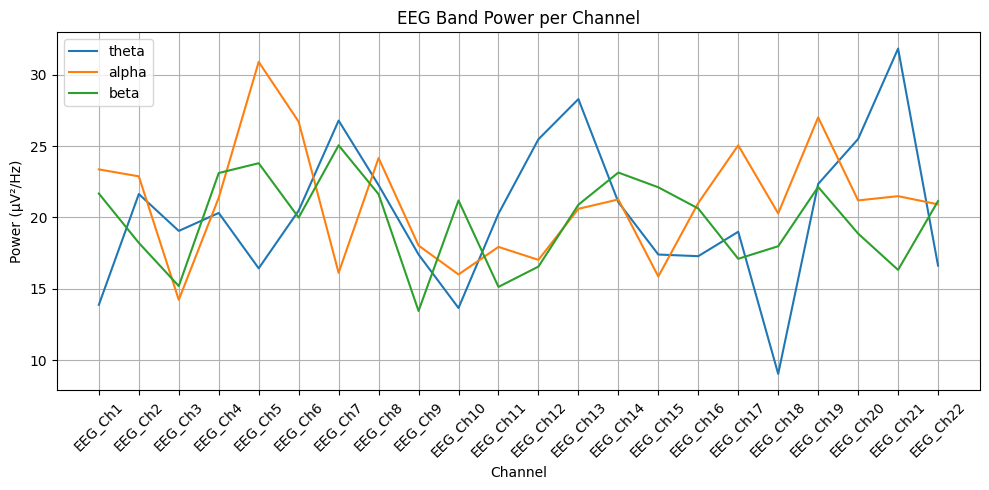


--- PCA and t-SNE Feature Visualization ---


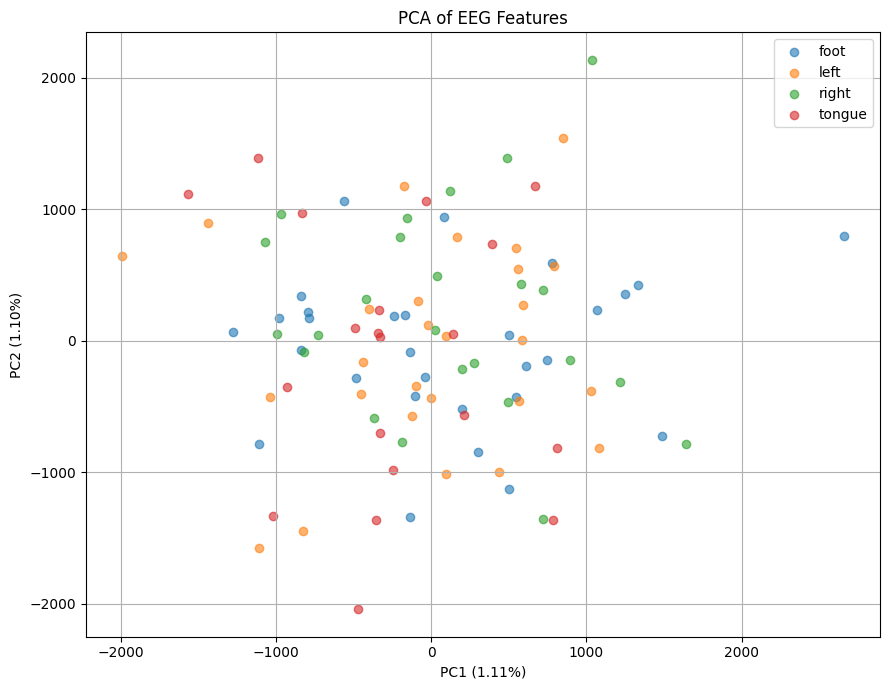

In [ ]:
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from scipy.fft import fft, rfftfreq
from scipy.signal import welch
import random

# --- Parameters for dummy data ---
n_samples = 100
n_channels = 22  # Standard for BCIC IV 2a
n_time_points = 1000  # Assuming 4 seconds at 250 Hz
sf = 250  # Sampling frequency

# Dummy raw EEG data (X)
X = np.random.randn(n_samples, n_channels, n_time_points) * 50

# Dummy labels (y)
labels = ['left', 'right', 'foot', 'tongue']
y = np.array(random.choices(labels, k=n_samples))

# EEG channel names
eeg_columns = [f'EEG_Ch{i+1}' for i in range(n_channels)]

# Normalize EEG data
scaler = StandardScaler()
X_reshaped = X.reshape(-1, n_time_points)
X_normalized_reshaped = scaler.fit_transform(X_reshaped)
X_normalized = X_normalized_reshaped.reshape(n_samples, n_channels, n_time_points)

# Frequency domain (FFT)
X_freq_real = np.abs(np.fft.rfft(X, axis=-1))

# Windowed features for PCA/t-SNE
X_windows = X  # Placeholder

# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = tf.keras.utils.to_categorical(y_encoded)

# --- Visualization: Raw EEG ---
print("--- Raw EEG Signal Visualization (Sample) ---")
left_indices = np.where(y == 'left')[0]
sample_idx = left_indices[0] if len(left_indices) > 0 else random.randint(0, n_samples - 1)
sample_data = X[sample_idx]

plt.figure(figsize=(15, 10))
for ch in range(sample_data.shape[0]):
    plt.plot(sample_data[ch] + ch * 10, label=f'Ch {eeg_columns[ch]}')
plt.yticks([ch * 10 for ch in range(sample_data.shape[0])], eeg_columns)
plt.title(f'EEG Raw Signal (Sample Index: {sample_idx}, Label: {y[sample_idx]})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Comparison: Raw vs Normalized ---
print("\n--- Raw vs. Normalized EEG Signal Comparison ---")
target_class = 'foot'
class_indices = np.where(y == target_class)[0]
sample_idx = class_indices[0] if len(class_indices) > 0 else random.randint(0, n_samples - 1)
raw_sample = X[sample_idx]
norm_sample = X_normalized[sample_idx]
start_time, end_time = 0, raw_sample.shape[1]
raw_clip = raw_sample[:, start_time:end_time]
norm_clip = norm_sample[:, start_time:end_time]
time_points = np.arange(start_time, end_time)

# Raw EEG
plt.figure(figsize=(10, 6))
for ch in range(n_channels):
    plt.plot(time_points, raw_clip[ch] + ch * 10)
plt.yticks([ch * 10 for ch in range(n_channels)], eeg_columns)
plt.title(f'Raw EEG (Label: {target_class})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.grid(True)
plt.tight_layout()
plt.show()

# Normalized EEG
plt.figure(figsize=(10, 6))
for ch in range(n_channels):
    plt.plot(time_points, norm_clip[ch] + ch * 2)
plt.yticks([ch * 2 for ch in range(n_channels)], eeg_columns)
plt.title(f'Normalized EEG (Label: {target_class})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Frequency-Domain Visualization ---
print("\n--- EEG Signal Frequency-Domain Visualization (FFT) ---")
sample_freq = X_freq_real[sample_idx]
freqs = rfftfreq(n_time_points, d=1/sf)

plt.figure(figsize=(10, 6))
offset = np.max(sample_freq) * 0.5
for ch in range(n_channels):
    plt.plot(freqs, sample_freq[ch] + ch * offset, lw=0.8)
plt.title(f'Frequency Spectrum (Sample Index: {sample_idx}, Label: {y[sample_idx]})')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (Offset for visibility)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Heatmap ---
print("\n--- Spectrogram-like EEG Heatmap ---")
plt.figure(figsize=(12, 8))
sns.heatmap(sample_data, cmap='viridis', yticklabels=eeg_columns, xticklabels=False)
plt.title(f'EEG Heatmap (Sample Index: {sample_idx}, Label: {y[sample_idx]})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.tight_layout()
plt.show()

# --- Band Power ---
print("\n--- EEG Band Power Calculation ---")
def bandpower(data, sf, band, window_sec=None):
    low, high = band
    nperseg = int(window_sec * sf) if window_sec else None
    freqs, psd = welch(data, sf, nperseg=nperseg)
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    return np.mean(psd[idx_band]) if np.any(idx_band) else 0.0

bands = {'theta': (4, 7), 'alpha': (8, 13), 'beta': (14, 30)}
band_powers = {band: [] for band in bands}

for ch in range(n_channels):
    signal = sample_data[ch]
    for band, band_range in bands.items():
        band_powers[band].append(bandpower(signal, sf, band_range, window_sec=2))

plt.figure(figsize=(10, 5))
for band in bands:
    plt.plot(band_powers[band], label=band)
plt.xticks(np.arange(n_channels), eeg_columns, rotation=45)
plt.title("EEG Band Power per Channel")
plt.xlabel("Channel")
plt.ylabel("Power (μV²/Hz)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PCA Visualization ---
print("\n--- PCA and t-SNE Feature Visualization ---")
X_flat = X_windows.reshape(n_samples, -1)
y_labels = np.argmax(y_categorical, axis=1)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

plt.figure(figsize=(9, 7))
for i in np.unique(y_labels):
    label = label_encoder.classes_[i] if i < len(label_encoder.classes_) else f'Class {i}'
    plt.scatter(X_pca[y_labels == i, 0], X_pca[y_labels == i, 1], label=label, alpha=0.6)
plt.title("PCA of EEG Features")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# *Model Creation*

In [ ]:
# Define input shape from X_train
channels = X.shape[1]
timesteps = X_train.shape[1]       # 50
features = X_train.shape[2]        # 22 * 2 = 44
num_classes = y_train.shape[1]     # 4

In [ ]:
channels

22

In [ ]:
def CNN_LSTM(input_shape, num_classes, dropoutRate=0.3, l2_reg = 0.002):
    input1 = Input(shape=input_shape)

    x = Conv1D(32, kernel_size=3, padding='same', activation='elu', kernel_regularizer=l2(l2_reg))(input1)
    x = BatchNormalization()(x)
    x = Dropout(dropoutRate)(x)

    x = Conv1D(64, kernel_size=3, padding='same', activation='elu', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(dropoutRate)(x)

    x = LSTM(128, return_sequences=True, dropout=dropoutRate)(x)
    x = LSTM(64, dropout=dropoutRate)(x)

    x = Dense(64, activation='elu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropoutRate)(x)
    x = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=input1, outputs=x)

In [ ]:
def GRU_Flatten_Model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    gru_out = GRU(256, return_sequences=True)(inputs)
    flatten_out = Flatten()(gru_out)
    outputs = Dense(num_classes, activation='softmax')(flatten_out)
    return Model(inputs=inputs, outputs=outputs)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dropout, Flatten, Dense
from tensorflow.keras import regularizers

def GRU_Regularized_Model(input_shape, num_classes, dropout_rate=0.2, l2_reg=0.002):
    inputs = Input(shape=input_shape)
    
    # GRU layer with L2 regularization
    gru_out = GRU(256, return_sequences=True,
                  kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    
    # Dropout for regularization
    gru_out = Dropout(dropout_rate)(gru_out)
    
    # Flatten before dense layer
    flatten_out = Flatten()(gru_out)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(flatten_out)
    
    return Model(inputs=inputs, outputs=outputs)


In [ ]:
# === Choose your model ===
#model = CNN_LSTM(input_shape=(timesteps, features), num_classes=num_classes, dropoutRate=0.3, l2_reg = 0.002)

#model = GRU_Flatten_Model(input_shape=(timesteps, features), num_classes=num_classes)

model = GRU_Regularized_Model(input_shape=(timesteps, features),num_classes=num_classes,dropout_rate=0.2, l2_reg=0.002)



model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

I0000 00:00:1755869579.295888      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755869579.296637      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50, 44)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 50, 256)             │         231,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │          51,204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 283,140 (1.08 MB)

 Trainable params: 283,140 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

# **Train Model**

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=6, 
                               restore_best_weights=True, 
                               mode='max')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.5, 
                                 patience=5, 
                                 min_lr=1e-6)

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler],
                    verbose=1)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/100


I0000 00:00:1755869584.452347      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


253/253 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.2625 - loss: 1.7020 - val_accuracy: 0.3178 - val_loss: 1.5150 - learning_rate: 5.0000e-04
Epoch 2/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3583 - loss: 1.4531 - val_accuracy: 0.3253 - val_loss: 1.4758 - learning_rate: 5.0000e-04
Epoch 3/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4044 - loss: 1.3606 - val_accuracy: 0.3277 - val_loss: 1.4885 - learning_rate: 5.0000e-04
Epoch 4/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4515 - loss: 1.2999 - val_accuracy: 0.3470 - val_loss: 1.4481 - learning_rate: 5.0000e-04
Epoch 5/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4992 - loss: 1.2153 - val_accuracy: 0.3742 - val_loss: 1.4115 - learning_rate: 5.0000e-04
Epoch 6/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5534 - loss: 1.1311 - val_accuracy: 0.4305 - val_loss: 1.3800 - learning_rate: 5.0000e-04
Epoch 7/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.61

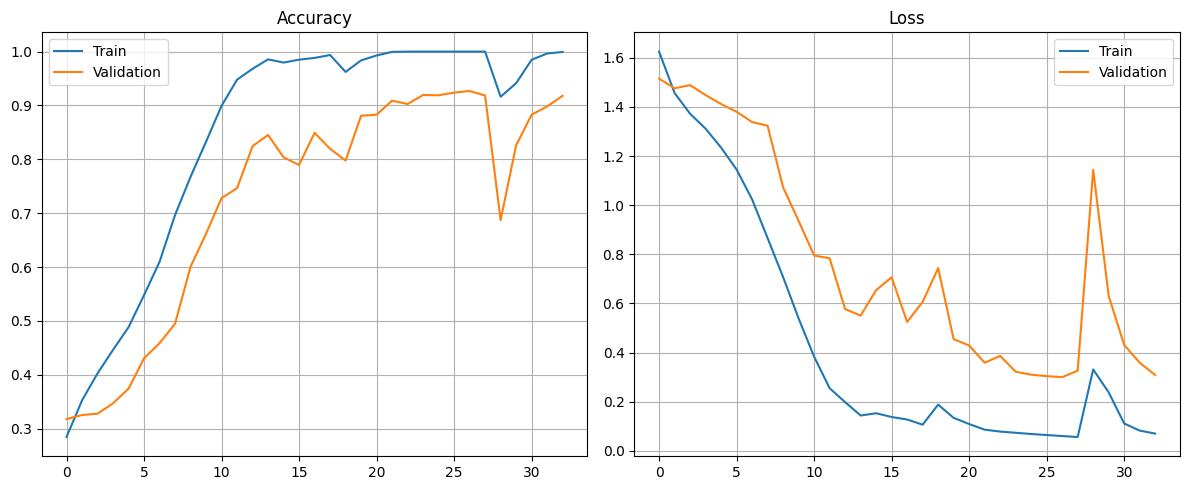

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_plot.png")
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, GRU, Bidirectional, BatchNormalization, Conv1D, GlobalAveragePooling1D,
    GlobalMaxPooling1D, Concatenate, Dense, Dropout, SpatialDropout1D
)
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

LR = 5e-4
L2 = 1e-3
DROPOUT_DENSE = 0.3
SPATIAL_DROPOUT = 0.15
UNITS_1 = 192  # smaller than 256 for speed
FILTERS = 64
KERNEL = 5
DENSE_UNITS = 128
LABEL_SMOOTH = 0.02

def Fast_BiGRU_CNN(input_shape, num_classes):
    inp = Input(shape=input_shape)

    # 1 Bidirectional GRU
    x = Bidirectional(
        GRU(UNITS_1, return_sequences=True, kernel_regularizer=regularizers.l2(L2))
    )(inp)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(SPATIAL_DROPOUT)(x)

    # Lightweight CNN block
    x = Conv1D(FILTERS, KERNEL, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Global pooling
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = Concatenate()([avg_pool, max_pool])

    # Dense classifier
    x = Dense(DENSE_UNITS, activation="relu", kernel_regularizer=regularizers.l2(L2))(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT_DENSE)(x)

    out = Dense(num_classes, activation="softmax")(x)
    return Model(inputs=inp, outputs=out)

# Build model
model = Fast_BiGRU_CNN(input_shape=(timesteps, features), num_classes=num_classes)

# Compile
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTH)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=loss_fn, metrics=["accuracy"])

model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6)

# Train
history = model.fit(X_train, y_train, batch_size=32, epochs=75,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler], verbose=1)

# Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 50, 44)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 50, 384)        │        274,176 │ input_layer_1[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 50, 384)        │          1,536 │ bidirectional[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout1d         │ (None, 50, 384)        │              0 │ batch_normalization[0… │
│ (SpatialDropout1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 50, 64)         │        122,944 │ spatial_dropout1d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 50, 64)         │            256 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 64)             │              0 │ batch_normalization_1… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 64)             │              0 │ batch_normalization_1… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128)            │              0 │ global_average_poolin… │
│                           │                        │                │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         16,512 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128)            │            512 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 4)              │            516 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 416,452 (1.59 MB)

 Trainable params: 415,300 (1.58 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/75
253/253 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.2642 - loss: 2.0278 - val_accuracy: 0.3164 - val_loss: 1.6497 - learning_rate: 5.0000e-04
Epoch 2/75
253/253 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.3140 - loss: 1.7195 - val_accuracy: 0.3391 - val_loss: 1.5955 - learning_rate: 5.0000e-04
Epoch 3/75
253/253 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.3567 - loss: 1.6149 - val_accuracy: 0.3663 - val_loss: 1.5439 - learning_rate: 5.0000e-04
Epoch 4/75
253/253 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.3803 - loss: 1.5521 - val_accuracy: 0.3791 - val_loss: 1.5267 - learning_rate: 5.0000e-04
Epoch 5/75
253/253 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4337 - loss: 1.4668 - val_accuracy: 0.4414 - val_loss: 1.4278 - learning_rate: 5.0000e-04
Epoch 6/75
253/253 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4575 - loss: 1.3944 - val_accuracy: 0.4765 - val_loss: 1.3737 - learning_rate: 5.0000e-04
Epoch 7/75
253/253 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - ac

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


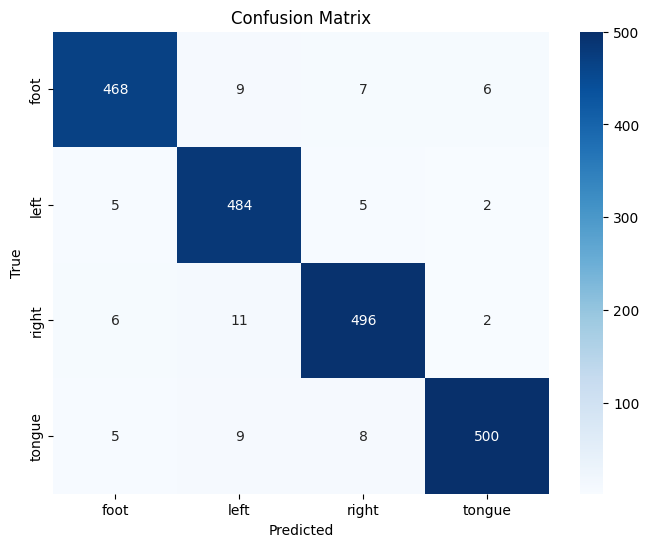

Classification Report:
              precision    recall  f1-score   support

        foot       0.97      0.96      0.96       490
        left       0.94      0.98      0.96       496
       right       0.96      0.96      0.96       515
      tongue       0.98      0.96      0.97       522

    accuracy                           0.96      2023
   macro avg       0.96      0.96      0.96      2023
weighted avg       0.96      0.96      0.96      2023

Accuracy: 0.9629


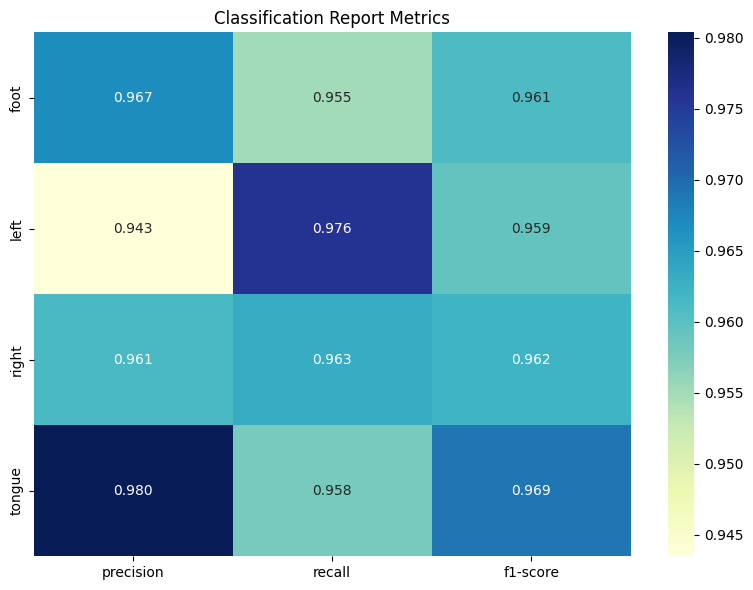

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


report = classification_report(y_true, y_pred, target_names=labels,output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-3, :-1].astype(float), 
            annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Classification Report Metrics')
plt.tight_layout()
plt.savefig('classification_report_heatmap.png', dpi=300)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")
